In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('owid-covid-data.csv')
df.head(3)

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df[(df['location'] =='Russia') & (df['date'] >= '2020-03-03')]

In [7]:
df = df[['date', 'total_cases', 'new_cases']].reset_index().drop('index', axis=1)

In [8]:
df = df.reset_index().rename(columns={'index':'nday'})

In [23]:
df.to_csv('covid-russia.csv', index=False, header=True)

In [9]:
df.head()

,nday,date,total_cases,new_cases
0,0,2020-03-03,3,1
1,1,2020-03-04,4,1
2,2,2020-03-05,4,0
3,3,2020-03-06,4,0
4,4,2020-03-07,10,6


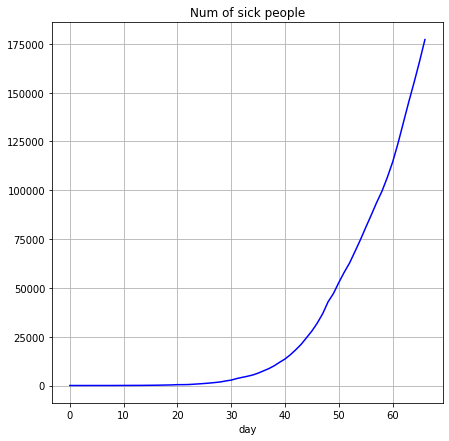

In [7]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(df['nday'].values, df['total_cases'].values, color='blue')
ax.set(xlabel='day', title='Num of sick people')
ax.grid()
plt.show()

### Обучим модель с экспоненциальным числом заболевших

$$ y \sim \exp (\alpha \cdot x+\beta) \Leftrightarrow \ln y \sim \alpha \cdot x+\beta$$

In [11]:
from sklearn.linear_model import LinearRegression

In [172]:
df['total_cases_log'] = np.log(df['total_cases'])

In [173]:
df['nday'] = df['nday'] + 1

In [174]:
train = df[:50]
test = df[50:]

In [175]:
lr = LinearRegression()
lr.fit(train['nday'].values.reshape(-1, 1), train['total_cases_log'].values)
print("Alpha = %.4f, Beta = %.4f" % (lr.coef_[0], lr.intercept_))

Alpha = 0.2033, Beta = 1.0724


In [176]:
alpha, beta = lr.coef_[0], lr.intercept_

In [177]:
df['lr_pred'] = lr.predict(df['nday'].values.reshape(-1, 1))

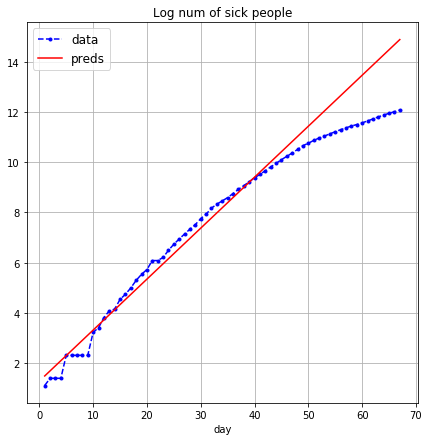

In [66]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(df['nday'].values, df['total_cases_log'].values, color='blue', marker='.', linestyle='dashed', label='data')
ax.plot(df['nday'].values, df['lr_pred'].values, color='red', label='preds')
ax.set(xlabel='day', title='Log num of sick people')
ax.grid()
plt.legend(fontsize='large')
plt.show()

Возвращаясь в изначальные координаты

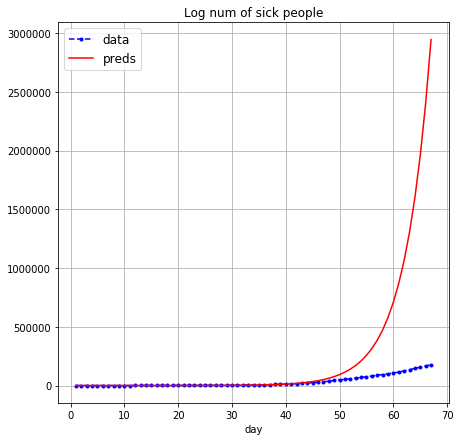

In [70]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(df['nday'].values, df['total_cases'].values, color='blue', marker='.', linestyle='dashed', label='data')
ax.plot(df['nday'].values, np.exp(df['lr_pred'].values), color='red', label='preds')
ax.set(xlabel='day', title='Log num of sick people')
ax.grid()
plt.legend(fontsize='large')
plt.show()

Seems so sad :(

### Let's go Bayes

Рассмотрим априорное распределение весов с учетом построенной модели и насемплируем экспоненты

In [173]:
from scipy.stats import multivariate_normal

# create data
N = 250
xs = np.linspace(0, 60, N)
X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 2))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
#     plt.scatter([-.5], [.5], marker='*', s=120)
    plt.show()

(250, 250)


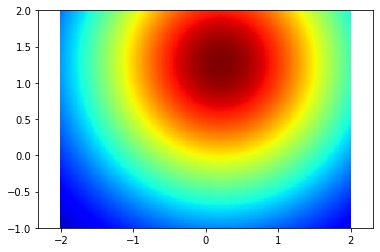

In [217]:
cur_mu, cur_sigma = np.array([alpha, beta]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)

Визуально семплинг выглядит так (по аналогии с лекцией #2)

In [218]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    plt.ylim((0, 10**5))
    plt.xlim((0, 60))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.show()

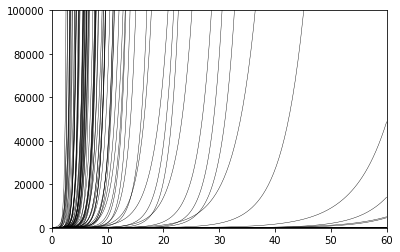

In [219]:
myplot_sample_lines(cur_mu, cur_sigma, 100)

Явно посчитаем "добавку" к линейной модели и апостериорное распределение

[слайд 42, 2 лекция]

In [222]:
def bayesian_update(mu, sigma, x, y, sn):
    x_matrix = x
#     x_matrix = np.array([[1, x]])
#     print(x_matrix)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sn ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sn ** 2)) * np.matmul(np.transpose(x_matrix), y ) )#np.array([y]) ) )
    return mu_n, sigma_n

In [227]:
sn = np.std(df['lr_pred'][50:] - df['total_cases_log'][50:])
px, py = train['nday'], train['total_cases_log']
post_mu, post_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sn)

In [228]:
post_mu

array([-0.41561061,  0.65678521])

In [229]:
post_sigma

array([[ 1.00000231, -0.99999769],
       [-0.99999769,  1.00000231]])

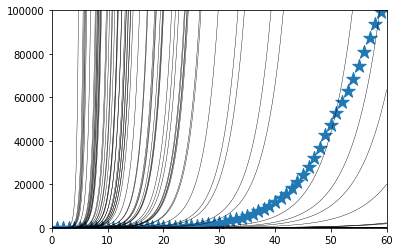

In [230]:
myplot_sample_lines(post_mu, post_sigma, 100, points=[df['nday'], df['total_cases']])

Не сходимся, потому что необходимо считать итеративно 

In [231]:
def bayesian_update(mu, sigma, x, y, sn):
    x_matrix = np.array([[1, x]])
#     print(x_matrix)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sn ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sn ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [127]:
sn = np.std(df['lr_pred'] - df['total_cases_log'])

post_mu, post_sigma = cur_mu, cur_sigma
for i in range(train.shape[0]):
    px, py = train['nday'][i], train['total_cases_log'][i]
    post_mu, post_sigma = bayesian_update(post_mu, post_sigma, px, py, sn)

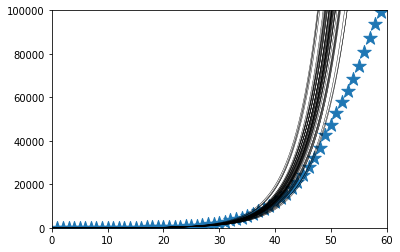

In [233]:
myplot_sample_lines(post_mu, post_sigma, 50, points=[df['nday'], df['total_cases']])

In [259]:
import datetime

def count_sick(mu, sigma, n=20, new_date='2020-05-01'):
    start_date = datetime.datetime.strptime('2020-03-03', '%Y-%m-%d')
    custom_date = datetime.datetime.strptime(new_date, '%Y-%m-%d')
    nday = 1 + (custom_date - start_date).days
    
    my_w = np.random.multivariate_normal(mu, sigma, n)
    # plt.axis('equal')
    df = pd.DataFrame(columns=['nday', 'value'])
    for w in my_w:
        df = df.append({'nday': nday, 'value': np.exp(w[0] + w[1]*nday)}, ignore_index=True)
    
    print("day = %d, prediction = %.0f" % (nday, df['value'].mean()))

Случаев короновируса к соответсвующим датам (отдельно отмечу, что мы усредняем по всем семплам, а не сами параметры распределения)

In [260]:
count_sick(post_mu, post_sigma, new_date='2020-05-01')
count_sick(post_mu, post_sigma, new_date='2020-06-01')
count_sick(post_mu, post_sigma, new_date='2020-09-01')

day = 60, prediction = 846909
day = 91, prediction = 440365013
day = 183, prediction = 93657514626718880


### Sigmoid approach

Здесь будем рассматривать накопительный эффект, то есть прирост числа заболевших.

Плотность распределения  $\frac{dF(x)}{dx} = \exp (\alpha_1 \cdot x^2 + \alpha_2 \cdot x + \beta)$, отсюда
$$ y \sim \exp (\alpha_1 \cdot x^2 + \alpha_2 \cdot x + \beta) \Leftrightarrow \ln y \sim \alpha_1 \cdot x^2 + \alpha_2 \cdot x + \beta$$

In [10]:
df['nday_squared'] = df['nday']**2

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [12]:
df['new_cases_log'] = np.log(df['new_cases'].replace(0, 1))

In [13]:
train = df[:50]
test = df[50:]

In [14]:
lr2 = LinearRegression()
lr2.fit(train[['nday', 'nday_squared']].values, train['new_cases_log'].values)
print("Alpha_1 = %.4f, Alpha_2 = %.4f, Beta = %.4f" % (lr2.coef_[0], lr2.coef_[1], lr2.intercept_))

Alpha_1 = 0.2598, Alpha_2 = -0.0014, Beta = -0.6141


In [15]:
alpha1, alpha2, beta = lr2.coef_[0], lr2.coef_[1], lr2.intercept_
df['lr2_pred'] = lr2.predict(df[['nday', 'nday_squared']].values)

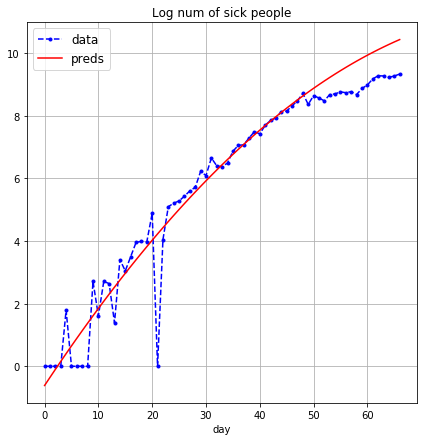

In [16]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(df['nday'].values, df['new_cases_log'].values, color='blue', marker='.', linestyle='dashed', label='data')
ax.plot(df['nday'].values, df['lr2_pred'].values, color='red', label='preds')
ax.set(xlabel='day', title='Log num of sick people')
ax.grid()
plt.legend(fontsize='large')
plt.show()

Возвращаясь в изначальные координаты

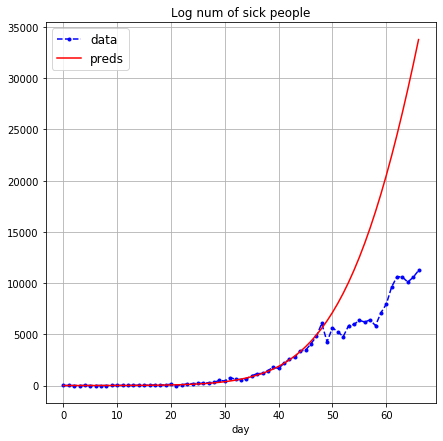

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(df['nday'].values, df['new_cases'].values, color='blue', marker='.', linestyle='dashed', label='data')
ax.plot(df['nday'].values, np.exp(df['lr2_pred'].values), color='red', label='preds')
ax.set(xlabel='day', title='Log num of sick people')
ax.grid()
plt.legend(fontsize='large')
plt.show()

### Let's go Bayes [2]

Обойдемся без трехмерного heatmap-a весов

In [18]:
from scipy.stats import multivariate_normal

# create data
N = 250
xs = np.linspace(0, 60, N)
X = np.linspace(-5, 5, N)
Y = np.linspace(-5, 5, N)
Z = np.linspace(-5, 5, N)

X, Y, Z = np.meshgrid(X, Y, Z)

pos = np.empty(X.shape + (3,))
pos[:, :, :, 0] = X
pos[:, :, :, 1] = Y
pos[:, :, :, 2] = Z

In [19]:
cur_mu, cur_sigma = np.array([beta, alpha1, alpha2]), 2*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [20]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs + w[2]*xs**2), 'k-', lw=.2)
    plt.ylim((0, 5000))
    plt.xlim((0, 50))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.show()

In [21]:
# myplot_sample_lines(cur_mu, cur_sigma, 100)

In [22]:
def bayesian_update(mu, sigma, x, y, sn):
    x_matrix = np.array([[1, x, x**2]])
#     print(x_matrix)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sn ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sn ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [23]:
sn = np.std(df['lr2_pred'] - df['new_cases_log'])

post_mu, post_sigma = cur_mu, cur_sigma
for i in range(train.shape[0]):
    px, py = train['nday'][i], train['new_cases_log'][i]
    post_mu, post_sigma = bayesian_update(post_mu, post_sigma, px, py, sn)
#     print(post_mu)

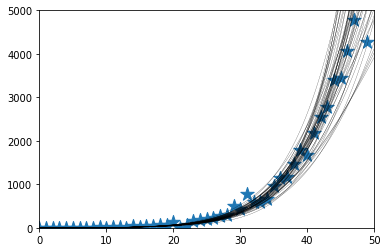

In [24]:
myplot_sample_lines(post_mu, post_sigma, 50, points=[df['nday'], df['new_cases']])

In [26]:
post_beta, post_alpha1, post_alpha2 = post_mu

xs = np.arange(1, 181, 1)
df_new = pd.DataFrame(xs, columns = ['nday'])
df_new['pred'] = np.exp(post_alpha1 * xs + post_alpha2 * xs**2 + post_beta)
df_new['pred_cumsum'] = df_new['pred'].cumsum()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  del sys.path[0]


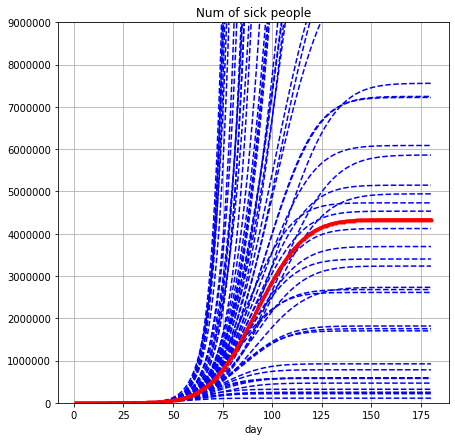

In [44]:
fig, ax = plt.subplots(figsize=(7,7))
plt.ylim(top=9e6)

out = []
for w0_sample, w1_sample, w2_sample in np.random.multivariate_normal(post_mu, post_sigma, 60):
    df_sample = pd.DataFrame(xs, columns = ['nday'])
    df_sample['pred'] = np.exp(w1_sample * xs + w2_sample * xs**2 + w0_sample)
    df_sample['pred_cumsum'] = df_sample['pred'].cumsum()
    
    plt.plot(df_new['nday'].values, df_sample['pred_cumsum'].values, color='blue', linestyle='dashed')
    out.append(df_sample.iloc[-1]['pred_cumsum'])

ax.plot(df_new['nday'].values, df_new['pred_cumsum'].values, linewidth=3, c='red', marker='.', lw=1, alpha=1)
ax.set(xlabel='day', title='Num of sick people')
ax.grid()
plt.show()

Прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? 

В оптимистичном сценарии (10-й процентиль)?

In [38]:
print("Пессимистичном сценарий: %.0f, \n Оптимистичном сценарий: %.0f" % (np.percentile(out, 90), np.percentile(out, 10)))

Пессимистичном сценарий: 277285800, 
 Оптимистичном сценарий: 226065


#### Продолжение размышлений во втором ноутбуке